In [1]:
import json
import os
from time import time
import pandas as pd
import numpy as np
from collections import Counter
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from sklearn.metrics import accuracy_score 
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import warnings

## Preprocessing

In [2]:
random_seed = 1
# Currently removing warnings to make the final notebook more attractive 
warnings.filterwarnings('ignore')

In [3]:
# json is formatted as list of albums
# albums are list of songs with lyrics and other metadata
def json_extract(path):
    data_list=[]
    for file in os.listdir(path): 
        if file[-5:] == '.json':
            with open(path+file, 'r') as f: 
                data = json.load(f)
                data_list.append(data)
    return data_list

In [4]:
path = 'data/drake/'
drake = json_extract(path)
path = 'data/quentin_miller/'
quentin = json_extract(path)

In [5]:
# remove obvious identifiers and stem words
stops = {'drizzy', 'drake', 'quentin', 'miller', 'ovo', 'champagne', 'papi','toronto', 'atlanta', '6'}
analyze = CV().build_analyzer()
ps = PorterStemmer()

def stop_removal(lyrics : str): 
    toks = analyze(lyrics)
    return ' '.join([ps.stem(word) for word in toks if not ps.stem(word) in stops])

In [6]:
np.random.seed(random_seed)
X_train = []
train_titles = []
d_train_cnt = 0
X_val = []
val_titles = []
d_val_cnt = 0
X_test = []
test_titles = []
d_test_cnt = 0
iyrtitl_lyrics = []
iyrtitl_titles = []

for album in drake: 
    for song in album: 
        sample_val = np.random.random(1)
        # keep track of "If you're..." to put in test set (iytitl is subject to ambiguous authorship)
        if song["album"] == "If You’re Reading This It’s Too Late ":
            iyrtitl_titles.append(song['title'])
            iyrtitl_lyrics.append(stop_removal(song['lyrics']))
        # oversample from Drake to balance training sample. 
        elif sample_val < .15:
            test_titles.append(song['title'])
            X_test.append(stop_removal(song['lyrics']))   
            d_test_cnt+=1
        elif sample_val >= .15 and sample_val <= .3:
            val_titles.append(song['title'])
            X_val.append(stop_removal(song['lyrics']))   
            d_val_cnt+=1
        else: 
            train_titles.append(song['title'])
            X_train.append(stop_removal(song['lyrics']))
            d_train_cnt+=1

for album in quentin: 
    for song in album:
        sample_val = np.random.random(1)
        if sample_val < .1:
            test_titles.append(song['title'])
            X_test.append(stop_removal(song['lyrics'])) 
        elif sample_val >= 0.1 and sample_val < 0.2:
            val_titles.append(song['title'])
            X_val.append(stop_removal(song['lyrics']))             
        else: 
            train_titles.append(song['title'])
            X_train.append(stop_removal(song['lyrics']))

# label drake as 0 and Quentin Miller as 1 in y column. 
y_train = np.zeros(len(X_train))    
y_train[d_train_cnt:] = 1
y_val = np.zeros(len(X_val))
y_val[d_val_cnt:] = 1
y_test = np.zeros(len(X_test))
y_test[d_test_cnt:] = 1

In [7]:
# keep track of CV accuracy of all models
training_scores = {}
# track the cross-validated best estimator. 
model_dict = {}

In [8]:
pipe_base = [ ('vect', CV(max_df=.5, ngram_range=(1, 2))), ('tfidf', TfidfTransformer())]
param_base = {   
    'vect__min_df': (0.002, 0.005, 0.007), 
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'), 
}

In [9]:
# takes a pipeline, hyperparameters, and a number of folds. 
# prints information about the grid search and returns the GridSearchCV object with the best model
def grid_search(pipeline, param, k=8):
    model = RandomizedSearchCV(pipeline, param, random_state=random_seed, 
                              cv=k, n_iter=8, verbose=0)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:", param)
    start = time()
    model.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - start))
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:")
    for param_name in sorted(param.keys()):
        print("\t%s: %r" % (param_name, model.best_params_[param_name]))
    return model

In [10]:
# adds results from gridsearch to global variables model_dict and training_scores 
# key should be a three letter abbreviation for the model's name. 
def track_model (key, pipeline, param, k=8):
    global model_dict
    global training_scores
    grid = grid_search(pipeline, param, k)
    model_dict[key] = grid.best_estimator_
    training_scores[key] = grid.best_score_

## Logistic Regression

In [11]:
pipeline = Pipeline(steps=
                    pipe_base + [('clf', LogisticRegression(class_weight='balanced', 
                               random_state=random_seed, 
                               penalty='elasticnet', 
                               solver='saga'))])
params = param_base.copy()
params['clf__l1_ratio'] = (0, 0.1, 0.5, 0.9)
params['clf__C'] = (0.1, 1., 10, 100, 1000)

In [12]:
track_model('log', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__l1_ratio': (0, 0.1, 0.5, 0.9), 'clf__C': (0.1, 1.0, 10, 100, 1000)}
done in 83.643s
Best score: 0.850
Best parameters set:
	clf__C: 1000
	clf__l1_ratio: 0
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__min_df: 0.007


## Stochastic Gradient Decent

In [13]:
# use modified_huber to ensure we get probability estimates
pipeline = Pipeline(steps=pipe_base + [('clf', SGDClassifier(class_weight='balanced', 
                          random_state=random_seed,  loss='modified_huber'))])
params = param_base.copy()
params['clf__alpha'] = (0.0001, 0.001, 0.01)
params['clf__l1_ratio'] =(0, 0.5, 0.75, 1)
params['clf__tol'] = (0.0001, 0.001)

In [14]:
track_model('sgd', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.0001, 0.001, 0.01), 'clf__l1_ratio': (0, 0.5, 0.75, 1), 'clf__tol': (0.0001, 0.001)}
done in 21.408s
Best score: 0.854
Best parameters set:
	clf__alpha: 0.01
	clf__l1_ratio: 0.75
	clf__tol: 0.0001
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__min_df: 0.002


## Support Vector Classification

In [15]:
# Use linear kernel to ensure probability estimates 
pipeline = Pipeline(steps=
    pipe_base + [('clf', SVC(kernel='linear', random_state=random_seed, 
                             class_weight='balanced', probability=True))])

params = param_base.copy()
params['clf__C'] = (0.1, 0.5, 0.75, 0.9)

In [16]:
track_model('svc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__C': (0.1, 0.5, 0.75, 0.9)}
done in 96.882s
Best score: 0.864
Best parameters set:
	clf__C: 0.75
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__min_df: 0.005


## Random forest 

In [17]:
pipeline = Pipeline(steps=pipe_base + [('clf', RandomForestClassifier(class_weight='balanced'))])

params = param_base.copy()
params['clf__n_estimators'] = (100, 150, 200) 
params['clf__max_features'] = (50, 75, 100)

In [18]:
track_model('rfc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__n_estimators': (100, 150, 200), 'clf__max_features': (50, 75, 100)}
done in 59.623s
Best score: 0.844
Best parameters set:
	clf__max_features: 100
	clf__n_estimators: 200
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__min_df: 0.005


## AdaBoost

In [19]:
pipeline = Pipeline(steps=pipe_base+[('clf', AdaBoostClassifier(random_state=random_seed))])

params = param_base.copy()
params['clf__base_estimator'] = (DTC(max_depth=1), DTC(max_depth=2), DTC(max_depth=4))
params['clf__n_estimators'] = (100, 120, 140)
params['clf__learning_rate'] = (1, 2)

In [20]:
track_model('ada', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__base_estimator': (DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=4)), 'clf__n_estimators': (100, 120, 140), 'clf__learning_rate': (1, 2)}
done in 201.979s
Best score: 0.786
Best parameters set:
	clf__base_estimator: DecisionTreeClassifier(max_depth=2)
	clf__learning_rate: 1
	clf__n_estimators: 120
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__min_df: 0.007


## Gradient Boosting

In [21]:
pipeline = Pipeline(steps=
                    pipe_base + [('clf', GradientBoostingClassifier(random_state=random_seed))])

params = param_base.copy()
params['clf__learning_rate'] =(0.5, 0.1)
params['clf__n_estimators'] = (50, 75, 100)
params['clf__max_depth'] = (2, 5)
params['clf__tol'] =  (0.0001, 0.001)

In [22]:
track_model('gbc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__learning_rate': (0.5, 0.1), 'clf__n_estimators': (50, 75, 100), 'clf__max_depth': (2, 5), 'clf__tol': (0.0001, 0.001)}
done in 308.454s
Best score: 0.803
Best parameters set:
	clf__learning_rate: 0.1
	clf__max_depth: 2
	clf__n_estimators: 75
	clf__tol: 0.001
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__min_df: 0.007


## Ensemble

In [23]:
# Produces the average of prediction probabilities all the models (unweighted)
# We've removed the machine learning model from this method because it doesn't improve over the baseline accuracy. 
def ensemble_proba(corpus): 
    arr = np.zeros((len(corpus), 2*(len(model_dict))))
    preds = np.zeros(len(corpus))
    for ind, key in enumerate(model_dict): 
        corp = model_dict[key]['vect'].transform(corpus)
        corp = model_dict[key]['tfidf'].transform(corp)
        probs = model_dict[key]['clf'].predict_proba(corp)
        arr[:, 2*ind] = probs[:, 0]
        arr[:, 2*ind+1] = -probs[:, 1]
    preds = np.sum(arr, axis=1)
    return(preds/(2*len(model_dict))+.5)


In [24]:
# predicts using a majority wins approach. 
# NOTE: ties favor Drake (lean towards false negatives)
def ensemble_pred(corpus): 
    arr = np.zeros((len(corpus), (len(model_dict))))
    preds = np.zeros(len(corpus))
    for ind, key in enumerate(model_dict): 
        corp = model_dict[key]['vect'].transform(corpus)
        corp = model_dict[key]['tfidf'].transform(corp)
        arr[:, ind] = model_dict[key]['clf'].predict(corp)
    preds = np.sum(arr, axis=1)
    f = lambda x: 1 if (x > 3) else 0
    return np.array([f(pred) for pred in preds])

## Results

### Model Comparisons

In [25]:
df_models = pd.DataFrame(index=training_scores.keys(), columns = ['CV', 'train', 'validation', 'test'])
df_models['CV'] = training_scores.values()
training = np.zeros(len(training_scores))
validation = np.zeros(len(training_scores))
for ind, key in enumerate(model_dict): 
    X_trans = model_dict[key]['vect'].transform(X_train)
    X_trans = model_dict[key]['tfidf'].transform(X_trans)
    training[ind] = accuracy_score(y_train, model_dict[key]['clf'].predict(X_trans))
    print(key, " train: {:.2f}".format(accuracy_score(y_train, model_dict[key]['clf'].predict(X_trans))))
    X_trans = model_dict[key]['vect'].transform(X_val)
    X_trans = model_dict[key]['tfidf'].transform(X_trans)
    validation[ind] = accuracy_score(y_val, model_dict[key]['clf'].predict(X_trans))
    print(key, " validation: {:.2f}".format(accuracy_score(y_val, model_dict[key]['clf'].predict(X_trans))))


df_models['train'] = training
df_models['validation'] = validation

# add ensemble method prediction
df2=pd.DataFrame(np.array([float('Nan'),
        accuracy_score(y_train,ensemble_pred(X_train)), 
        accuracy_score(y_val,ensemble_pred(X_val)),
        float("Nan")]).reshape(1,4), 
    columns=["CV", 'train', 'validation', 'test'], 
    index=['ens'])

df_models = df_models.append(df2)


log  train: 1.00
log  validation: 0.91
sgd  train: 1.00
sgd  validation: 0.93
svc  train: 1.00
svc  validation: 0.91
rfc  train: 1.00
rfc  validation: 0.86
ada  train: 1.00
ada  validation: 0.75
gbc  train: 0.99
gbc  validation: 0.89


In [26]:
df_models

,CV,train,validation,test
log,0.850413,0.996599,0.909091,NaN
sgd,0.853885,1.000000,0.931818,NaN
svc,0.864302,1.000000,0.909091,NaN
rfc,0.843656,1.000000,0.863636,NaN
ada,0.786130,1.000000,0.750000,NaN
gbc,0.802834,0.993197,0.886364,NaN
ens,NaN,1.000000,0.931818,NaN


In [27]:
best_key = df_models['validation'].idxmax()
print("The best model is: ", best_key)

The best model is:  sgd


In [28]:
testing = np.zeros(len(training_scores)+1)
for ind, key in enumerate(model_dict): 
    X_trans = model_dict[key]['vect'].transform(X_test)
    X_trans = model_dict[key]['tfidf'].transform(X_trans)
    testing[ind] = accuracy_score(y_test, model_dict[key]['clf'].predict(X_trans))
    print(key, " test: {:.2f}".format(accuracy_score(y_test, model_dict[key]['clf'].predict(X_trans))))
# add ensemble to test scores
testing[ind+1] = accuracy_score(y_test, ensemble_pred(X_test))
print("ens test: {:.2f}".format(testing[ind+1] ))
df_models['test'] = testing

log  test: 0.95
sgd  test: 0.97
svc  test: 0.95
rfc  test: 0.95
ada  test: 0.92
gbc  test: 0.92
ens test: 0.98


In [29]:
df_models

,CV,train,validation,test
log,0.850413,0.996599,0.909091,0.949153
sgd,0.853885,1.000000,0.931818,0.966102
svc,0.864302,1.000000,0.909091,0.949153
rfc,0.843656,1.000000,0.863636,0.949153
ada,0.786130,1.000000,0.750000,0.915254
gbc,0.802834,0.993197,0.886364,0.915254
ens,NaN,1.000000,0.931818,0.983051


### Probability Predictions for *If You're Reading this it's Too Late* songs 

In [30]:
# track the test set predictions for held out "If You're Reading This its Too Late" 
df_iyrtitl = pd.DataFrame(np.zeros(len(iyrtitl_titles)), index=iyrtitl_titles, columns=["credits"])
credits = ['10 Bands', "Legend", "Know Yourself", "Used To"]
for name in credits:
    df_iyrtitl.loc[name]=1

In [31]:
# predictions for iyrtitl
for key in model_dict:
    test = model_dict[key]['vect'].transform(iyrtitl_lyrics)
    test = model_dict[key]['tfidf'].transform(test)
    df_iyrtitl[key+'_drake'] = model_dict[key]['clf'].predict_proba(test)[:,0]
    df_iyrtitl[key+'_quen'] = 1-df_iyrtitl[key+'_drake']
df_iyrtitl['ens_drake'] = ensemble_proba(iyrtitl_lyrics)
df_iyrtitl['ens_quen'] = 1-df_iyrtitl['ens_drake']
df_iyrtitl

,credits,log_drake,log_quen,sgd_drake,sgd_quen,svc_drake,svc_quen,rfc_drake,rfc_quen,ada_drake,ada_quen,gbc_drake,gbc_quen,ens_drake,ens_quen
Legend,1.0,0.565333,0.434667,0.551125,0.448875,0.797308,0.202692,0.645,0.355,0.698193,0.301807,0.950097,0.049903,0.701176,0.298824
Energy,0.0,0.535583,0.464417,0.567107,0.432893,0.866611,0.133389,0.685,0.315,0.647086,0.352914,0.768165,0.231835,0.678258,0.321742
10 Bands,1.0,0.422586,0.577414,0.422168,0.577832,0.054580,0.945420,0.505,0.495,0.401305,0.598695,0.091072,0.908928,0.316118,0.683882
Know Yourself,1.0,0.483324,0.516676,0.530560,0.469440,0.580991,0.419009,0.525,0.475,0.670139,0.329861,0.672732,0.327268,0.577124,0.422876
No Tellin’,0.0,0.397930,0.602070,0.420479,0.579521,0.043857,0.956143,0.535,0.465,0.410981,0.589019,0.178765,0.821235,0.331169,0.668831
Madonna,0.0,0.565927,0.434073,0.581733,0.418267,0.876083,0.123917,0.640,0.360,0.603965,0.396035,0.890037,0.109963,0.692958,0.307042
6 God,0.0,0.553799,0.446201,0.577404,0.422596,0.892606,0.107394,0.610,0.390,0.688915,0.311085,0.753773,0.246227,0.679416,0.320584
Star67,0.0,0.505667,0.494333,0.517164,0.482836,0.500000,0.500000,0.620,0.380,0.451188,0.548812,0.412854,0.587146,0.501146,0.498854
Preach,0.0,0.553045,0.446955,0.579748,0.420252,0.843543,0.156457,0.580,0.420,0.646174,0.353826,0.669016,0.330984,0.645254,0.354746
Wednesday Night Interlude,0.0,0.593760,0.406240,0.528795,0.471205,0.660715,0.339285,1.000,0.000,0.731238,0.268762,0.822235,0.177765,0.722791,0.277209


In [32]:
# Best model's prediction
df_iyrtitl[[best_key+'_drake', best_key+ "_quen"]]

,sgd_drake,sgd_quen
Legend,0.551125,0.448875
Energy,0.567107,0.432893
10 Bands,0.422168,0.577832
Know Yourself,0.530560,0.469440
No Tellin’,0.420479,0.579521
Madonna,0.581733,0.418267
6 God,0.577404,0.422596
Star67,0.517164,0.482836
Preach,0.579748,0.420252
Wednesday Night Interlude,0.528795,0.471205


In [33]:
def predict_proba(key, data): 
    data = model_dict[best_key]['vect'].transform(data)
    data = model_dict[best_key]['tfidf'].transform(data)
    return model_dict[best_key]['clf'].predict_proba(data)

In [34]:
def predict(key, data):
    data = model_dict[best_key]['vect'].transform(data)
    data = model_dict[best_key]['tfidf'].transform(data)
    return model_dict[best_key]['clf'].predict(data)

In [35]:
# test predictions for best model
preds = predict_proba(best_key, X_test)
test_predictions_df = pd.DataFrame(preds, index=test_titles, columns=['drake_prob', 'quen_prob'])
test_predictions_df['prediction'] = predict(best_key, X_test)
test_predictions_df['true'] = y_test
test_predictions_df

,drake_prob,quen_prob,prediction,true
How Bout Now,0.599184,0.400816,0.0,0.0
Days in the East,0.778653,0.221347,0.0,0.0
Draft Day,0.552434,0.447566,0.0,0.0
Girls Love Beyoncé,0.584277,0.415723,0.0,0.0
Certified Lover Boy*,0.621046,0.378954,0.0,0.0
Intro,0.544125,0.455875,0.0,0.0
The Presentation,0.642267,0.357733,0.0,0.0
Replacement Girl,0.563154,0.436846,0.0,0.0
The Last Hope,0.606373,0.393627,0.0,0.0
Underdog,0.584909,0.415091,0.0,0.0


### Feature Importances

In [36]:
# track words that are best "drake" predictors, "miller" predictors
drake_tokens = []
quentin_tokens = []
cdf = pd.DataFrame(model_dict[best_key]['clf'].coef_.T, 
                model_dict[best_key]['vect'].get_feature_names(), 
                columns=['Coefficients']).sort_values(['Coefficients'])

In [37]:
# Best Drake predictors 
cdf[:10]

,Coefficients
re,-0.616383
girl,-0.597024
love,-0.501082
you re,-0.493205
oh,-0.440959
caus,-0.416775
oh oh,-0.406595
are,-0.365757
night,-0.358589
down,-0.352862


In [38]:
# Best Quentin Miller predictors
cdf[-10:]

,Coefficients
back,0.337875
live,0.341869
hit,0.390559
nike,0.393624
not,0.403000
wa,0.417126
let,0.419718
came,0.469392
ain,0.599668
yeah yeah,0.600212


### Comparison of Drake Albums

In [39]:
# reorganize corpus by album for further exploration of which songs are most "Drake-like"
album_dict = {}
song_titles_dict = {}
for album in drake: 
    if len(album) < 10:
        continue
    album_dict[album[0]['album'].strip()] = [stop_removal(song['lyrics']) for song in album]
    song_titles_dict[album[0]['album'].strip()] = [song['title'] for song in album]

In [40]:
album_mean = {}
for album_key in album_dict:
    X_train = model_dict[best_key]['tfidf'].transform(model_dict[best_key]['vect'].transform(album_dict[album_key]))
    preds = model_dict[best_key]['clf'].predict_proba(X_train)[:,0]
    album_mean[album_key]=np.mean(preds)

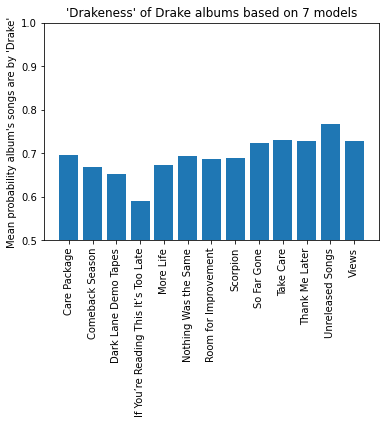

In [41]:
plt.bar(album_mean.keys(), album_mean.values())
plt.xticks(range(len(album_mean)), album_mean.keys(), rotation='vertical')
plt.ylim(0.5,1)
plt.ylabel("Mean probability album's songs are by 'Drake'")
plt.title("'Drakeness' of Drake albums based on 7 models")
plt.show()